In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

 ### Prepare mean data for ploting

In [12]:
calculateMean = True

In [13]:
# rename the varaibles to Yordanka convenstion
def renameFrames(df):
    df['stim'].replace({'sum': 'B+F', 'Mon': 'M', 'MBody': 'B', 'MFace': 'F'}, inplace=True)
    df['type'].replace({'Irr': 'U', 'R':'N'}, inplace=True)
    df['layer'] = df['layer'].str.replace(r'(\w{5})',r'\1 ',regex=True).str.strip('\-')
    df['network'].replace({'alexnet': 'AlexNet', 'vgg16': 'VGG-16', 'alexnet_caffe': 'AlexNet (caffe)'}, inplace=True)
    return df

In [14]:
if calculateMean:
    # read the grand dataframe (a 8GB csv file) file  :(
    df_all_all = pd.read_csv('../results/data/dataframes/grand_df_all.csv')
    # df_sum_all = pd.read_csv('../results/data/dataframes/grand_df_sum.csv')

    # df_sum_all = renameFrames(df_sum_all)
    df_all_all = renameFrames(df_all_all) # takes around 5 minutes ( consider putting it after df_final?)

    # summing the response of body and face and concatinate to the dataframe
    df_all_all_B = df_all_all[df_all_all.stim == 'B']
    df_all_all_F = df_all_all[df_all_all.stim == 'F']

    df_all_all_sum = df_all_all_B.copy()
    df_all_all_sum['resp'] = df_all_all_B.resp.values + df_all_all_F.resp.values 
    df_all_all_sum['stim'].replace({'B': 'B+F'}, inplace=True)
    df_all_final = pd.concat([df_all_all, df_all_all_sum], axis=0)

    # mean across image id's [for across units change 'units' to 'id']
    s_final = df_all_final.groupby(
        ['reg_sel', 'std_val', 'trained', 'network', 'layer', 'stim', 'type', 'nUnits', 'nSelUnits', 'units'])['resp'].mean()
    df_final = pd.DataFrame({'Mean Response': s_final})
    df_final = df_final.reset_index()

    # save it to bypass loading big dataframe and renaming
    df_final.to_csv('../results/data/dataframes/meanData_plot.csv')

### Ploting:

In [15]:
df_final = pd.read_csv('../results/data/dataframes/meanData_plot.csv')

In [17]:
# palette = sns.color_palette("bright", n_colors=2)
palette = ["#0000ff99", "#ff000099"]
palette = sns.color_palette(palette, 2)
sns.set_context(context='paper')

In [18]:
# this function prints the number and percent of selected units in a layer in facetgrid object
def annotate_nUnits(g, data, **kws):
    N = data.groupby(['network', 'layer', 'nSelUnits', 'nUnits']).count().reset_index().nSelUnits.values
    tN =data.groupby(['network', 'layer', 'nSelUnits', 'nUnits']).count().reset_index().nUnits.values
    frac_N = np.round((np.divide(N, tN))*100, 2)
    id = 0
    for ax in g.axes.flat:
        ax.text(0.1, 0.80,f'n={N[id]}\n({frac_N[id]}%)', \
             fontsize=9, transform=ax.transAxes, bbox = dict(facecolor='white', alpha=0.7, edgecolor='gray'))
        id +=1

reg/ireg:   0%|          | 0/2 [00:00<?, ?it/s]























reg/ireg:  50%|█████     | 1/2 [00:51<00:51, 51.55s/it]

























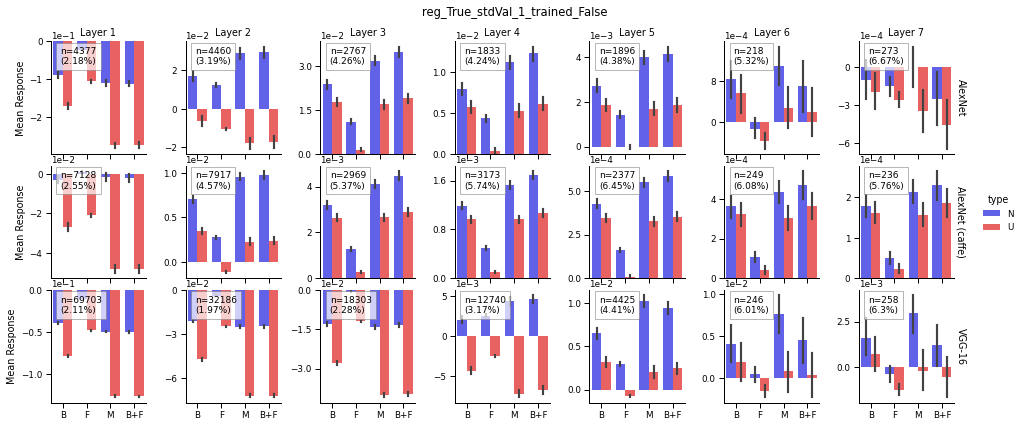

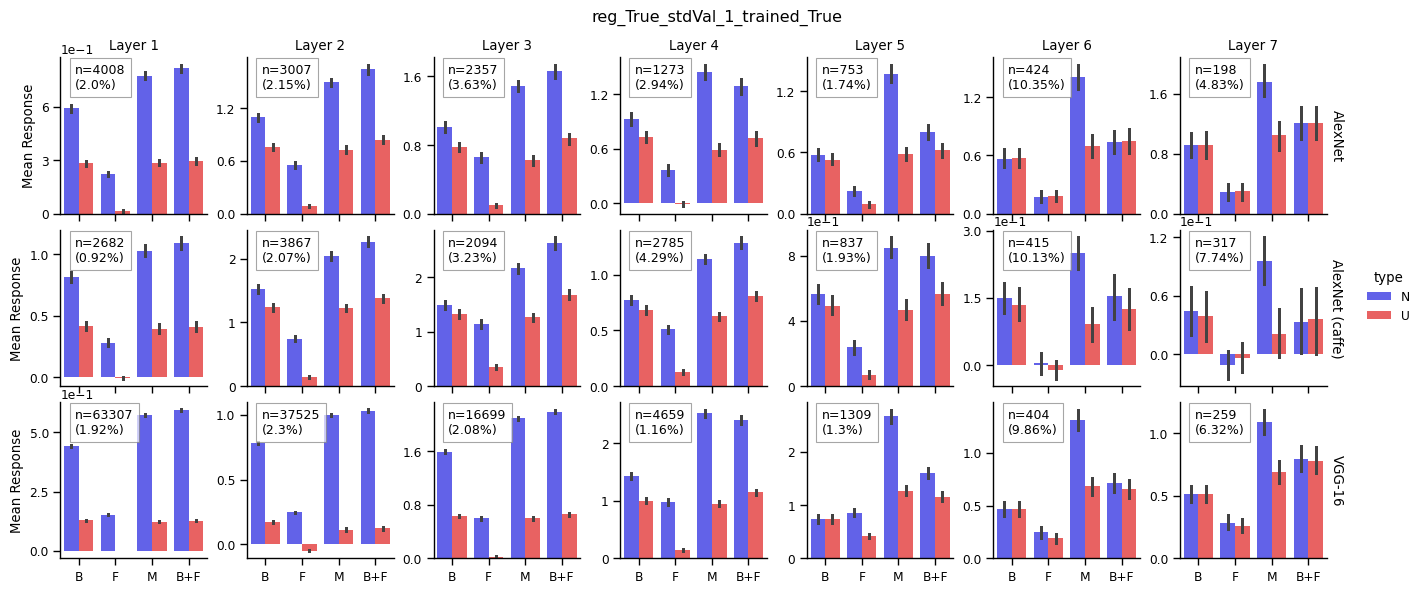

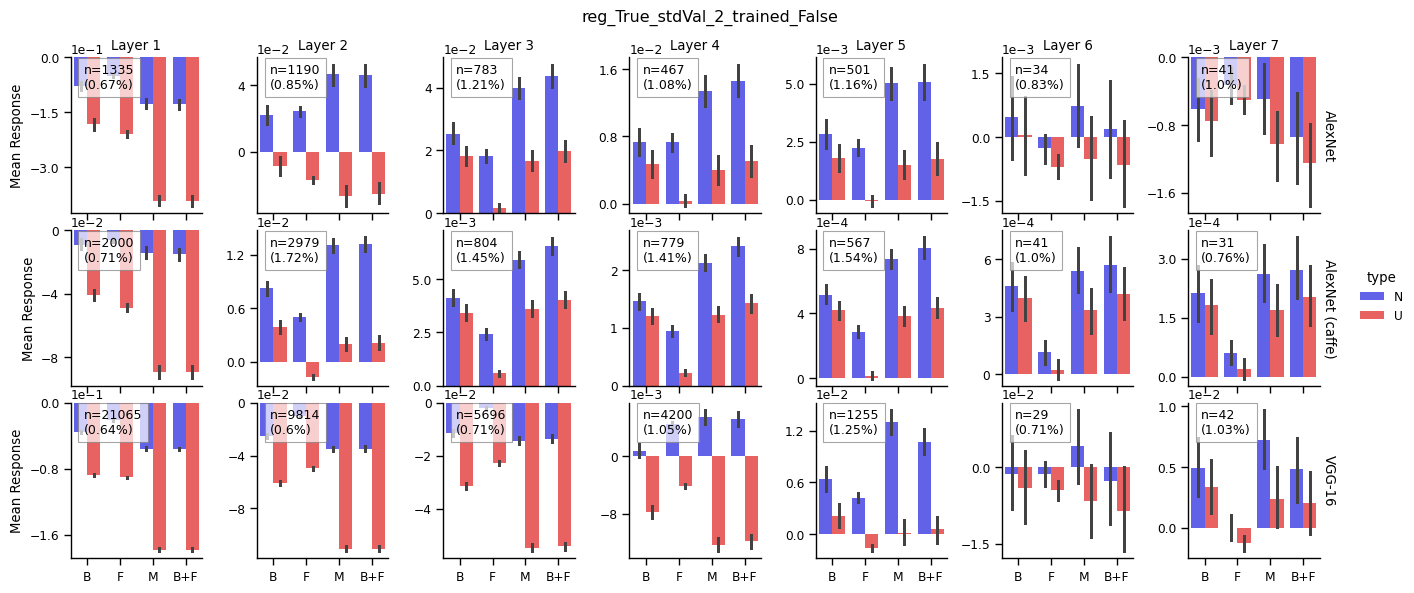

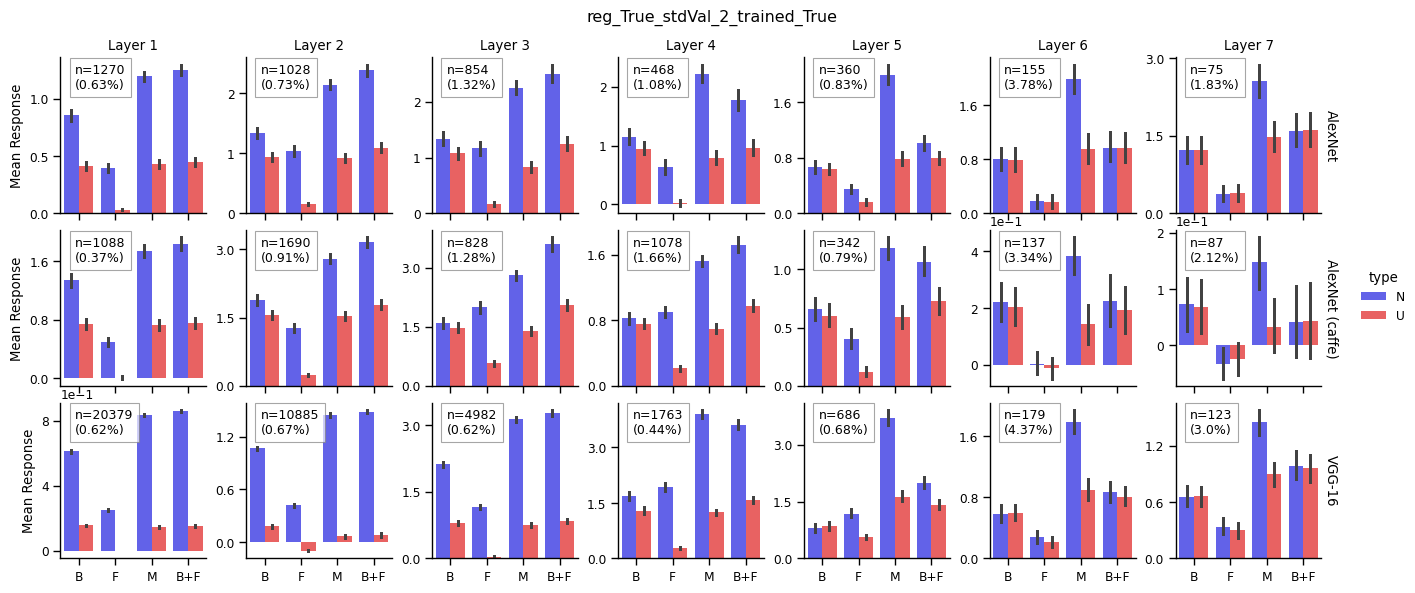

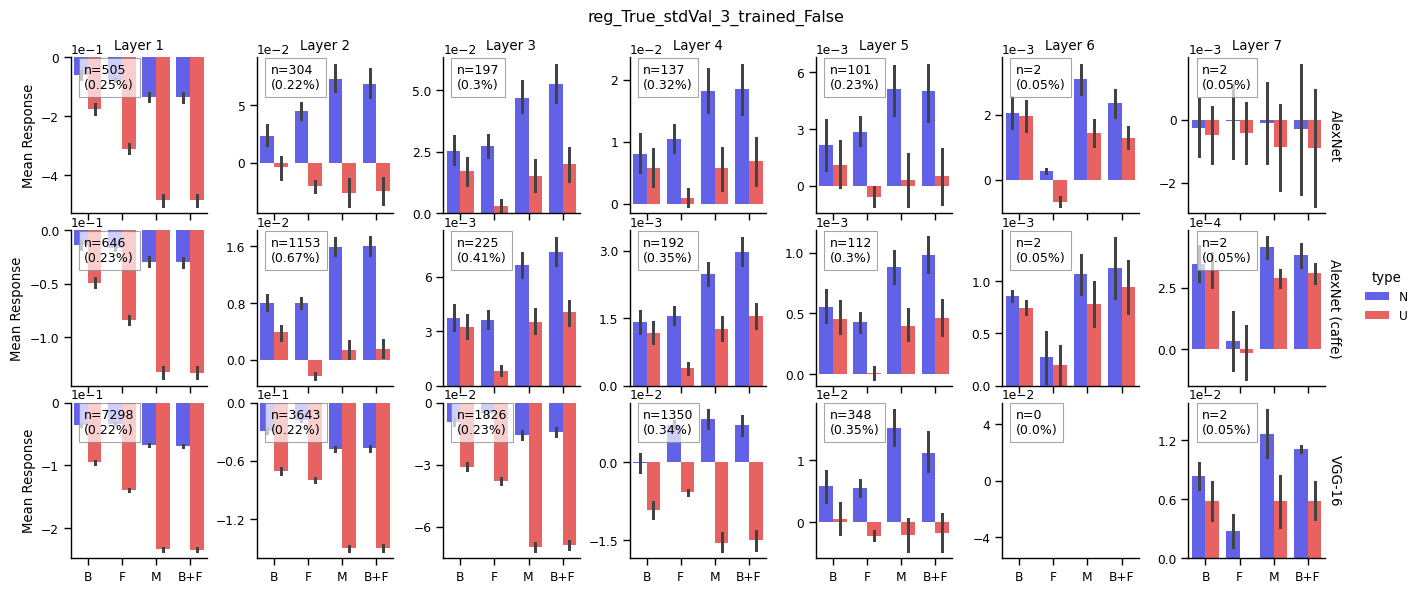

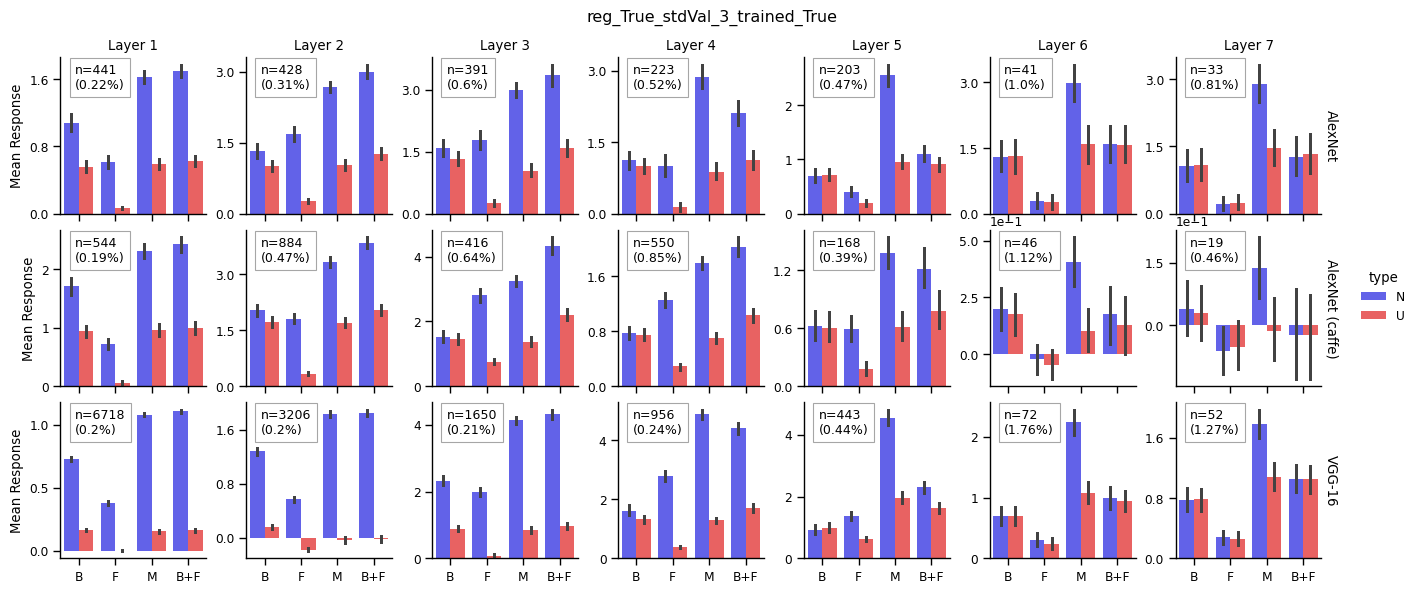

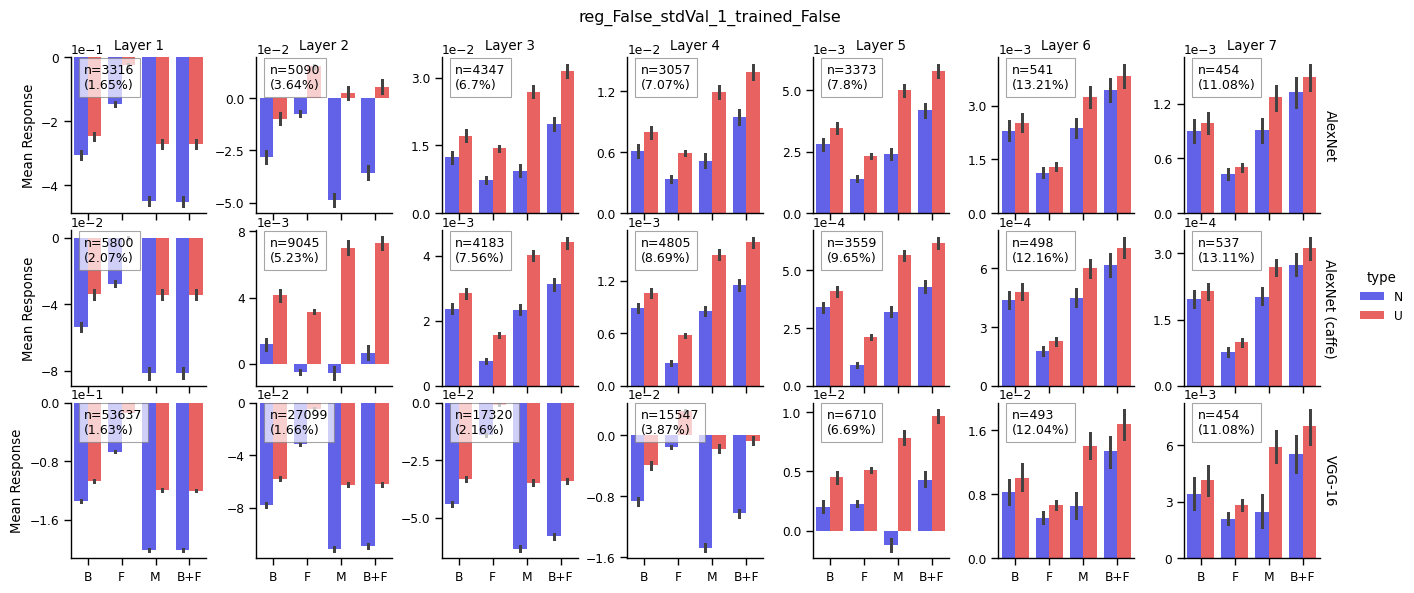

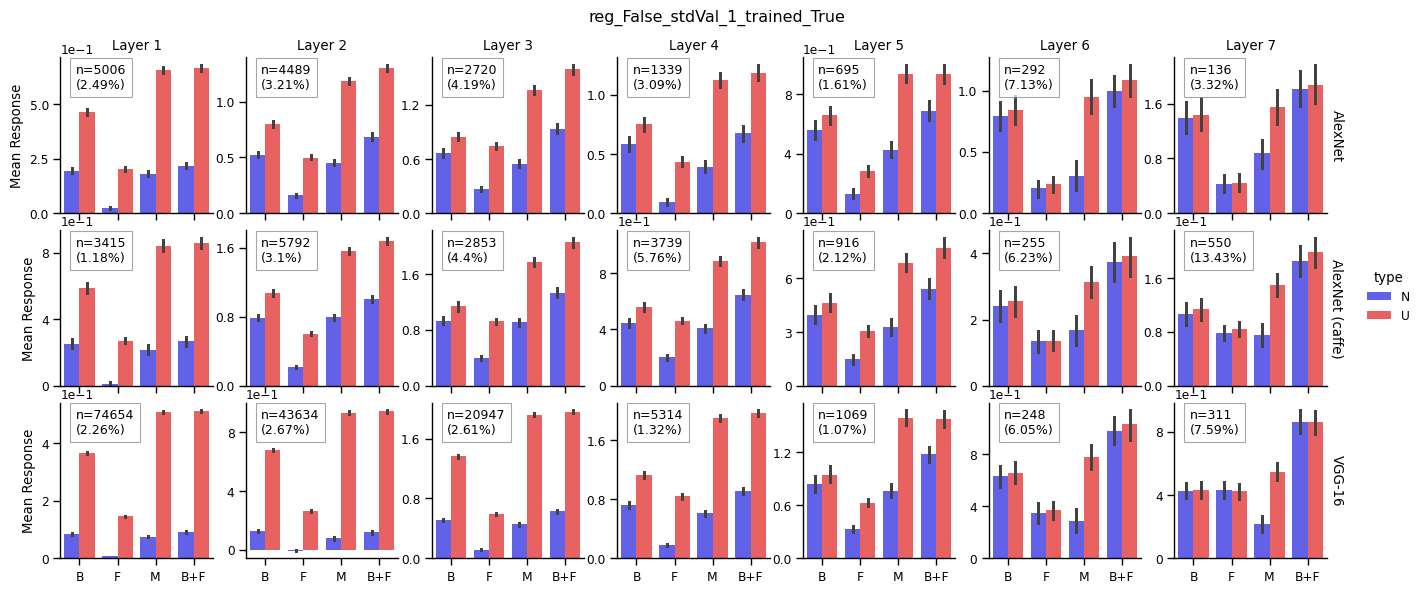

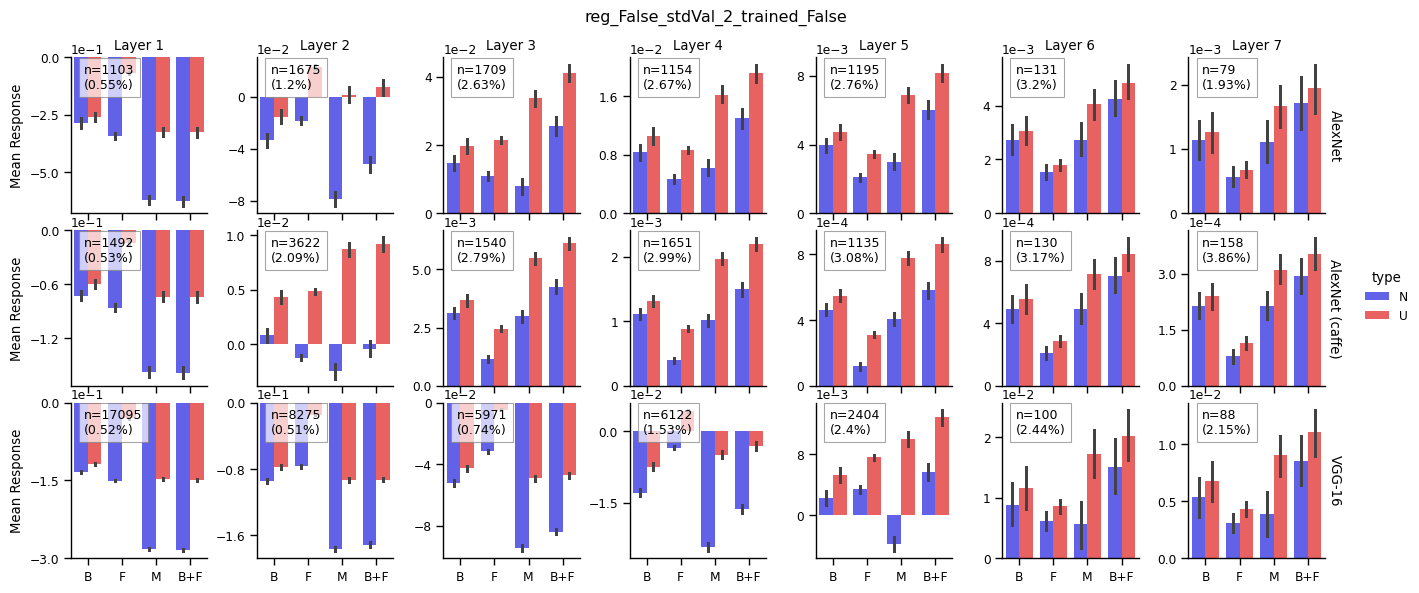

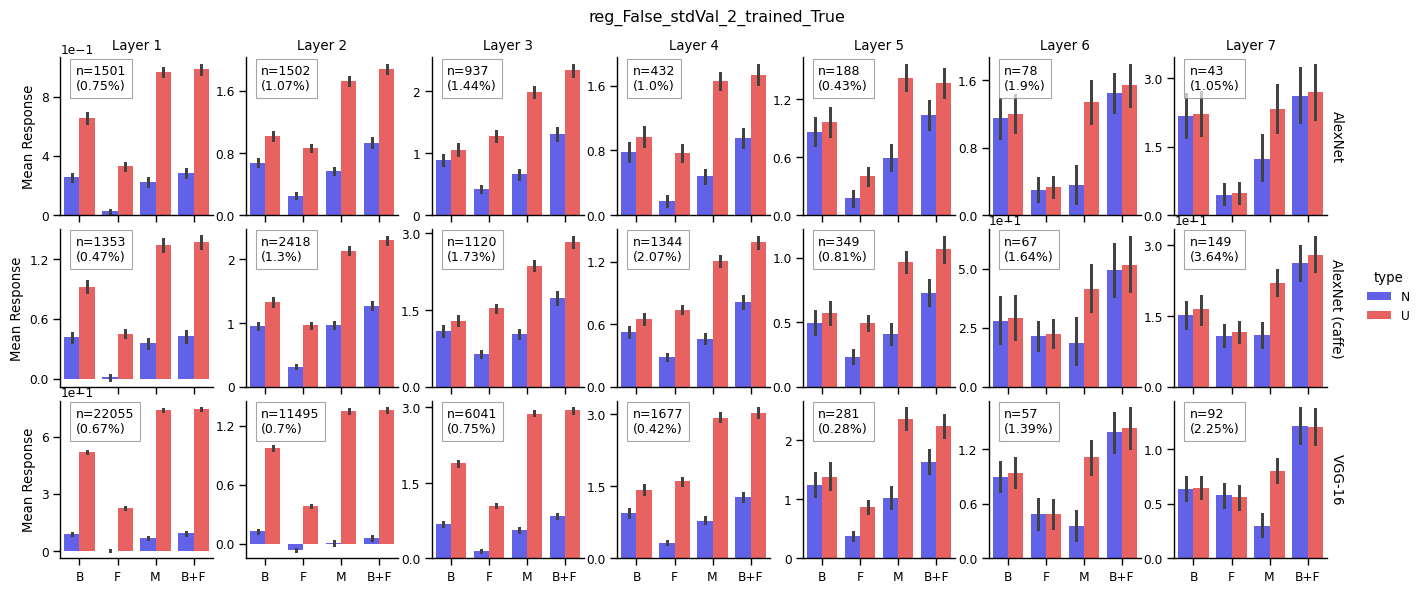

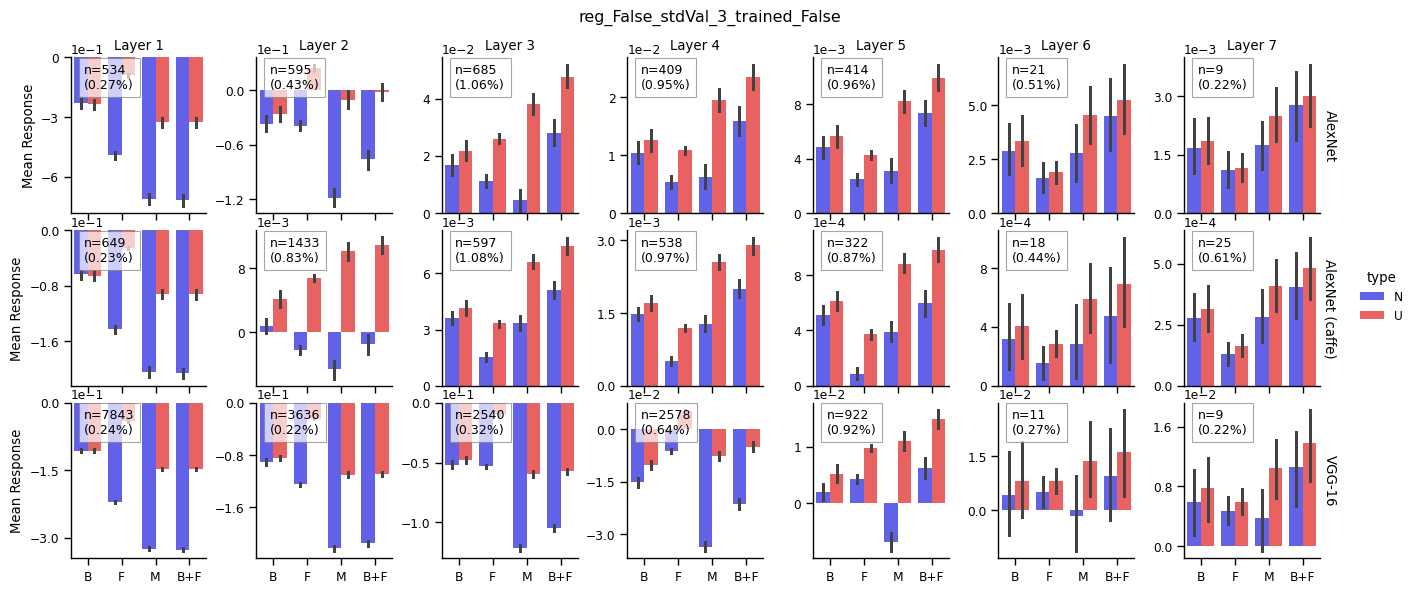

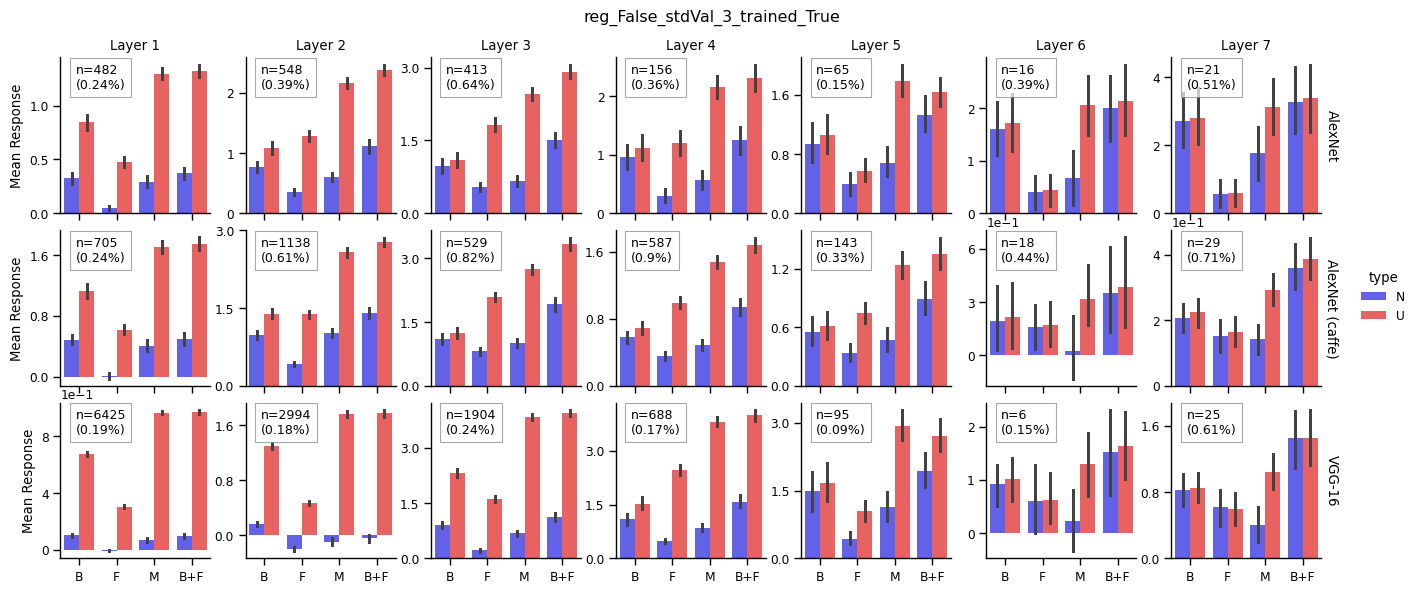

In [19]:
# ploting for all the variables

trained_nets = [False, True]
reg_sels = [True, False]
std_vals = [1, 2, 3]
for reg_sel in tqdm(reg_sels, desc="reg/ireg", position=0, leave=False):
    for std_val in tqdm(std_vals, desc="std_val", position=1, leave=False):
        for trained_net in tqdm(trained_nets, desc="trained/untrained", position=3, leave=False):

            df_select = df_final[(df_final.reg_sel == reg_sel) & (df_final.std_val == std_val) & (df_final.trained == trained_net)]
            g = sns.FacetGrid(data=df_select.reset_index(), col='layer',
                  row='network', height=3, aspect=1, margin_titles=True, sharey=False)
            g.map_dataframe(sns.barplot, x='stim', y='Mean Response', hue='type', alpha=.7, palette=palette, order = ['B', 'F', 'M', 'B+F'])
            g.add_legend(title='type')
            g.fig.subplots_adjust(top=.90)
            g.fig.suptitle(f'reg_{reg_sel}_stdVal_{std_val}_trained_{trained_net}')
            g.fig.set_size_inches(14, 6)
            g.set_titles(row_template='{row_name}', col_template='{col_name}', )
            g.set_xlabels('')
            annotate_nUnits(g, df_select)
            for axes in g.axes.flat:
                axes.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
                axes.yaxis.set_major_locator(plt.MaxNLocator(3))
            g.fig.savefig(f'../results/plots/meanResp_reg_{reg_sel}_stdVal_{std_val}_trained_{trained_net}.pdf', format='pdf', bbox_inches = 'tight', dpi=300)

In [84]:
# compute correlatin between diff_M (Natural - Unatural monkey) and diff_sum (Natural monkey - (natural Face + natural Body))
df_alexnet = df_final[(df_final.network == 'AlexNet') & \
            (df_final.std_val == 2) & \
            (df_final.trained == True) & \
            (df_final.reg_sel == True)]

corr_val = []
for ilayer in range(1, 8):

    df_sliced = df_alexnet[df_alexnet.layer == f'Layer-{ilayer}']
    MN = df_sliced[(df_sliced.stim == 'M') & (df_sliced.type == 'N')]['Mean Response'].values
    MU= df_sliced[(df_sliced.stim == 'M') & (df_sliced.type == 'U')]['Mean Response'].values
    BF = df_sliced[(df_sliced.stim == 'B+F') & (df_sliced.type == 'N')]['Mean Response'].values

    from scipy.stats import pearsonr
    diff_M = MN-MU
    diff_sum = MN-BF
    corval = pearsonr(diff_M, diff_sum)
    corr_val.append(corval)

In [85]:
corr_val

[(-0.03929904043526705, 0.16161400102996434),
 (-0.15739288080575398, 3.9385595899575103e-07),
 (0.029466064155719153, 0.3897777395548436),
 (0.38213659377588266, 1.0147273287355378e-17),
 (0.7717106856274812, 2.331614508170496e-72),
 (0.4722897176724622, 5.497331984587733e-10),
 (0.6181486569017286, 3.4442567082044695e-09)]

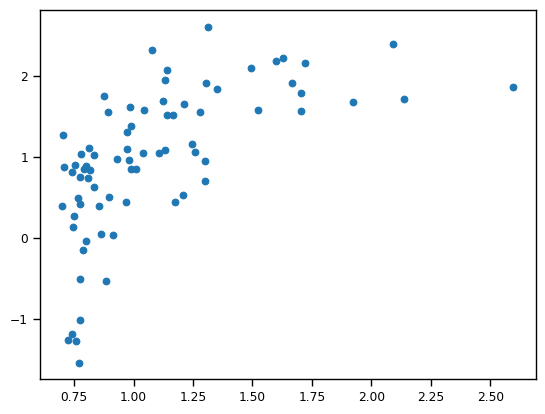

In [86]:
plt.scatter(diff_M,diff_sum)